In [5]:
import os
import subprocess
import random
import warnings
import numpy as np
from scipy.linalg import sqrtm
from scipy.stats import unitary_group
import pandas as pd
import matplotlib.pyplot as plt

import yaml
from tqdm.notebook import tqdm
import itertools

import torch
from qucumber.nn_states import DensityMatrix
from qucumber.callbacks import MetricEvaluator
import qucumber.utils.unitaries as unitaries
import qucumber.utils.training_statistics as ts
import qucumber.utils.cplx as cplx
import qucumber.utils.data as data
from qucumber.observables import ObservableBase, to_pm1
from qucumber.observables.pauli import flip_spin
import qucumber

from qulacs.gate import Pauli

%load_ext autoreload
%autoreload 2
import target_circuit
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
with open('./params_setting.yaml', 'r') as yml:
    params = yaml.safe_load(yml)
    
# quantum circuit parameter
circuit_name = params["circuit_info"]["circuit_name"]
n_qubit = params["circuit_info"]["n_qubit"]
state_class = params["circuit_info"]["state_class"]
error_model = params["circuit_info"]["error_model"]
error_rate = params["circuit_info"]["error_rate"]
each_n_shot = params["circuit_info"]["each_n_shot"]

# RBM architecture parameter
num_visible = params["architecture_info"]["n_visible_unit"]
num_hidden = params["architecture_info"]["n_hidden_unit"] 
num_aux = params["architecture_info"]["n_aux_unit"]

# train parameter
lr = params["train_info"]["lr"]
pbs = params["train_info"]["positive_batch_size"]
nbs = params["train_info"]["negative_batch_size"]
n_gibbs_step = params["train_info"]["n_gibbs_step"]
period = 1
epoch = params["train_info"]["n_epoch"]
lr_drop_epoch = params["train_info"]["lr_drop_epoch"]
lr_drop_factor = params["train_info"]["lr_drop_factor"]
use_gpu = params["train_info"]["use_gpu"]
seed = params["train_info"]["seed"]

# sampling parameter
n_sampling = params["sampling_info"]["n_sample"]
n_copy = params["sampling_info"]["n_copy"]

# data path info
environment = "local"
if environment == "local":
    train_data_path = f"./{circuit_name}/data/{n_qubit}-qubit/{error_model}/p={100*error_rate}%/each_{each_n_shot}_shot/"
    target_state_path = f"./{circuit_name}/target_state/{state_class}/{n_qubit}-qubit/{error_model}/p={100*error_rate}%/"
    model_path = f"./{circuit_name}/model/{state_class}/{n_qubit}-qubit/{error_model}/p={100*error_rate}%/each_{each_n_shot}_shot/"
    train_log_path = f"./{circuit_name}/train_log/{n_qubit}-qubit/{error_model}/p={100*error_rate}%/each_{each_n_shot}_shot/"
if environment == "colab":
    from google.colab import drive
    drive.mount("/content/drive/")
    drive_path = "/content/drive/MyDrive/NQS4VD/GHZ"
    train_data_path = drive_path + f"/{circuit_name}/data/{n_qubit}-qubit/{error_model}/p={100*error_rate}%/each_{each_n_shot}_shot/"
    target_state_path = drive_path + f"/{circuit_name}/target_state/{state_class}/{n_qubit}-qubit/{error_model}/p={100*error_rate}%/"
    model_path = drive_path + f"/{circuit_name}/model/{state_class}/{n_qubit}-qubit/{error_model}/p={100*error_rate}%/each_{each_n_shot}_shot/"
    train_log_path = drive_path + f"/{circuit_name}/train_log/{n_qubit}-qubit/{error_model}/p={100*error_rate}%/each_{each_n_shot}_shot/"


def seed_settings(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    qucumber.set_random_seed(seed, cpu=True, gpu=False)

seed_settings(seed=seed)

### depolarizing error

In [7]:
# load train log
train_log_dep_df = pd.read_csv(f"./{circuit_name}/train_log/{n_qubit}-qubit/{error_model}/p={100*error_rate}%/each_{each_n_shot}_shot/train_log.csv")

ideal_state = target_circuit.GHZ(n_qubit, state_class, "ideal", error_rate)
noisy_state = target_circuit.GHZ(n_qubit, state_class, "depolarizing", error_rate)
ideal_noisy_fidelity = utils.fidelity(ideal_state, noisy_state)

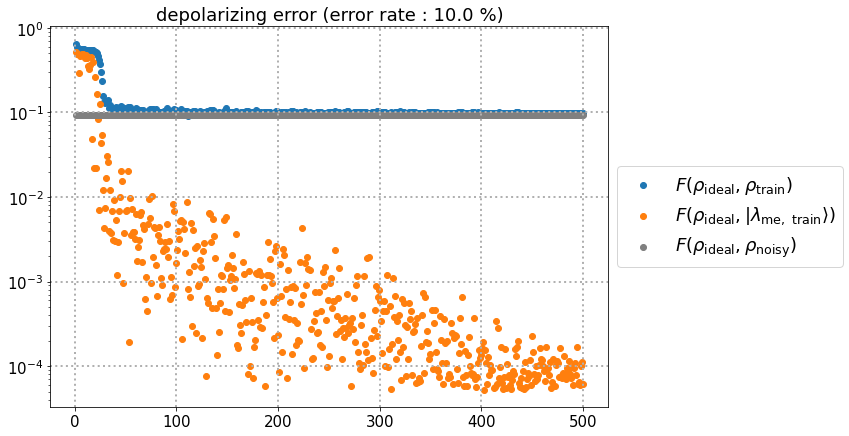

In [12]:
x = train_log_dep_df["epoch"].values
tick_label = np.arange(1, 501).astype("str")
labels = [r"$F(\rho_{\rm ideal}, \rho_{\rm train})$", 
          #r"$F(\rho_{\rm noisy}, \rho_{\rm train})$", 
          r"$F(\rho_{\rm ideal}, | \lambda_{\rm me,\ train} \rangle)$",
          r"$F(\rho_{\rm ideal}, \rho_{\rm noisy})$"]

plt.figure(figsize=(10, 7))
plt.scatter(x, 1-train_log_dep_df["F_ideal_train"].values)
#plt.scatter(x, 1-train_log_dep_df["noisy_fidelity"].values)
plt.scatter(x, 1-train_log_dep_df["F_ideal_meve"].values)
plt.scatter(x, 1-np.repeat(ideal_noisy_fidelity, 500), c = "grey")

plt.title(f'depolarizing error (error rate : {error_rate*100} %)', fontsize=18)
plt.yscale('log')
#plt.xlabel("Epoch", fontsize=18)
#plt.ylabel('Infidelity', fontsize=18)
plt.tick_params(labelsize=15)
plt.grid(linestyle='dotted', linewidth=2)
plt.legend(labels, loc='center left', bbox_to_anchor=(1., .5), fontsize=18)
plt.savefig(f"./{circuit_name}/train_log/{n_qubit}-qubit/{error_model}/p={100*error_rate}%/each_{each_n_shot}_shot/plot_fidelity.pdf", bbox_inches='tight')